# Section 2.5: Spiked models

This page contains simulations in Section 2.5

## Contents

    - Empirical eigenvalues of spiked sample covariance versus the Marcenko-Pastur law
    - Theorem 2.13: alignment of isolated eigenvectors
    - Theorem 2.14: fluctuation of the largest eigenvalue and the Tracy-Widom distribution


## Empirical eigenvalues of spiked sample covariance versus the Marcenko-Pastur law

with isolated "spike" empirical eigenvalues predicted per Theorem 2.12

In [88]:
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
import scipy.special
import matplotlib.pyplot as plt
pi = np.pi

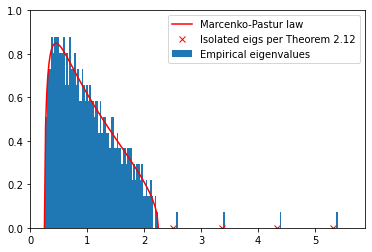

In [89]:
coeff = 1
p = 512*coeff
n = p*4
c = p/n

np.random.seed(928)
Z = np.mat(np.random.randn(p,n))
eig_P = np.array([1,2,3,4])
P = np.mat(np.diag(np.concatenate([eig_P,np.zeros(p-len(eig_P))])))
C = np.eye(p) + P
X = scipy.linalg.sqrtm(C) @ Z

SCM = X @ (X.T)/n
eigs_SCM = np.sort(np.linalg.eig(SCM)[0])
edges=np.linspace(np.min(eigs_SCM)-.1,np.max(eigs_SCM)+.1,200)

a = (1-np.sqrt(c))**2
b = (1+np.sqrt(c))**2

isolated_eigs = 1+eig_P+c*(1+eig_P)/eig_P
isolated_eigs[ [ i for i in range(len(eig_P)) if eig_P[i]<=np.sqrt(c) ] ] = np.nan

plt.hist(eigs_SCM, bins=edges,weights=1/p/(edges[1]-edges[0])*np.ones(p),label='Empirical eigenvalues')
edges_MP=np.linspace(a,b,100)
mu=np.sqrt( (edges_MP-a)*(b-edges_MP) )/2/pi/c
plt.plot(edges_MP,mu/edges_MP,'r',label='Marcenko-Pastur law')
plt.plot(isolated_eigs,np.zeros(len(isolated_eigs)),'rx',label='Isolated eigs per Theorem 2.12')
plt.gca().set_xlim(0,np.max(eigs_SCM)+.5)
plt.gca().set_ylim(0,1)
_ = plt.legend()

## Theorem 2.13: alignment of isolated eigenvectors

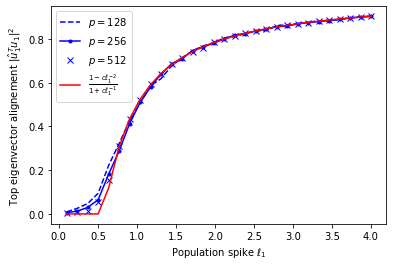

In [90]:
coeff_loop = [1,2,4]
popu_spike_loop = np.linspace(.1,4,30)
nb_average_loop = 100
eigvec_alignment = np.zeros( (len(coeff_loop),len(popu_spike_loop),nb_average_loop) )

np.random.seed(928)

for i in range(len(coeff_loop)):
    for j in range(len(popu_spike_loop)):
        for average_loop in range(nb_average_loop):
            p = int(128*coeff_loop[i])
            n = p*3
            c = p/n

            eig_P = popu_spike_loop[j]
            Z = np.mat(np.random.randn(p,n))

            u = np.mat(np.random.randn(p,1))
            u = u/np.linalg.norm(u)
            C = np.eye(p) + eig_P*u@(u.T)
            X = scipy.linalg.sqrtm(C) @ Z

            SCM = X@(X.T)/n
            hat_u = scipy.sparse.linalg.eigs(SCM,1)[1]

            eigvec_alignment[i,j,average_loop] = abs(u.T@hat_u)**2
        
max0 = lambda array : [ max(x,0) for x in array]
theo_alignment = max0((1-c*1/popu_spike_loop**2)/(1+c/popu_spike_loop))

plt.plot(popu_spike_loop,np.mean(eigvec_alignment[0,:,:],axis=1),'b--',label='$p=128$')
plt.plot(popu_spike_loop,np.mean(eigvec_alignment[1,:,:],axis=1),'b.-',label='$p=256$')
plt.plot(popu_spike_loop,np.mean(eigvec_alignment[2,:,:],axis=1),'bx',label='$p=512$')
plt.plot(popu_spike_loop,theo_alignment,'r',label=r'$\frac{1-c \ell_1^{-2}}{ 1+c \ell_1^{-1} }$')
plt.xlabel(r'Population spike $\ell_1$')
plt.ylabel(r'Top eigenvector alignement $| \hat u_1^T u_1 |^2$')
_ = plt.legend()

## Theorem 2.14: Fluctuation of the largest eigenvalue and the Tracy-Widom distribution

In [91]:
def tracy_widom_appx(x, i):
#
# [pdftwappx, cdftwappx]=tracywidom_appx(x, i)
#
# SHIFTED GAMMA APPROXIMATION FOR THE TRACY-WIDOM LAWS, by M. Chiani, 2014
# code publicly available https://www.mathworks.com/matlabcentral/fileexchange/44711-approximation-for-the-tracy-widom-laws
#
# TW ~ Gamma[k,theta]-alpha
#
# [pdf,cdf]=tracywidom_appx(x,i) for i=1,2,4 gives TW1, TW2, TW4
#

    kappx = [46.44604884387787, 79.6594870666346, 0, 146.0206131050228]   #  K, THETA, ALPHA
    thetaappx = [0.18605402228279347, 0.10103655775856243, 0, 0.05954454047933292]
    alphaappx = [9.848007781128567, 9.819607173436484, 0, 11.00161520109004]

    cdftwappx = cdfgamma(x+alphaappx[i-1], thetaappx[i-1], kappx[i-1])

    pdftwappx = pdfgamma(x+alphaappx[i-1], thetaappx[i-1], kappx[i-1])

    return pdftwappx, cdftwappx

def pdfgamma(x, ta, ka):
    pdf = []
    for x_ in x:
        if x_ > 0:
            pdf.append(1/(scipy.special.gamma(ka)*ta**ka) * x_**(ka - 1) * np.exp(-x_/ta))
        else:
            pdf.append(0)
    return pdf


def cdfgamma(x, ta, ka):
    cdf = []
    for x_ in x:
        if x_ > 0:
            cdf.append(scipy.special.gammainc(ka,x_/ta))
        else:
            cdf.append(0)
    return cdf

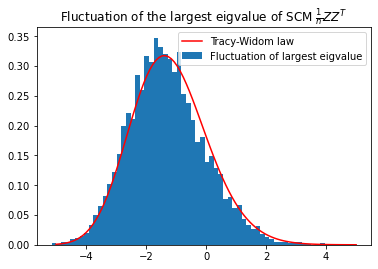

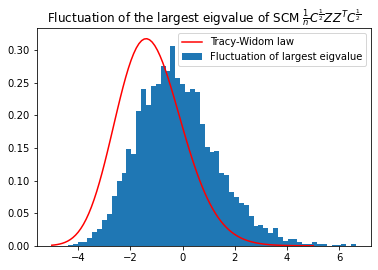

In [92]:
coeff = 2
p = 128*coeff
n = 256*coeff
c = p/n

nb_loop = 5000
eig_MP_max = []
eig_SCM_max = []

eig_P = np.sqrt(c)
sqrt_C= np.mat(np.diag(np.sqrt(np.concatenate([ [1+eig_P],np.ones(p-1) ]))))

np.random.seed(928)
for loop in range(nb_loop): # empirical evaluation
    Z = np.mat(np.random.randn(p,n))
    X = sqrt_C @ Z
    eig_MP_max.append(np.real(scipy.sparse.linalg.eigs(Z@Z.T/n,1)[0][0]))
    eig_SCM_max.append(np.real(scipy.sparse.linalg.eigs(X@X.T/n,1)[0][0]))


# without spikes
edges_MP = np.linspace(np.min(eig_MP_max),np.max(eig_MP_max),60)    
edges = np.linspace(-5,5,100)
factor = c**(-1/6)*(1+np.sqrt(c))**(4/3)

scaled_edges_MP = (edges_MP-(1+np.sqrt(c))**2)*n**(2/3)/factor
    
plt.hist( (eig_MP_max-(1+np.sqrt(c))**2)*n**(2/3)/factor,bins=scaled_edges_MP, weights=1/nb_loop/( scaled_edges_MP[1]-scaled_edges_MP[0] )*np.ones(len(eig_MP_max)) ,label=r'Fluctuation of largest eigvalue')
plt.plot(edges,tracy_widom_appx(edges,1)[0], 'r',label=r'Tracy-Widom law')
plt.title(r'Fluctuation of the largest eigvalue of SCM $\frac{1}{n} Z Z^T$')
_ = plt.legend()


# with spikes
edges_SCM = np.linspace(np.min(eig_SCM_max),np.max(eig_SCM_max),60)    
edges = np.linspace(-5,5,100)
factor = c**(-1/6)*(1+np.sqrt(c))**(4/3)

scaled_edges_SCM = (edges_SCM-(1+np.sqrt(c))**2)*n**(2/3)/factor

plt.figure()
plt.hist( (eig_SCM_max-(1+np.sqrt(c))**2)*n**(2/3)/factor,bins=scaled_edges_SCM, weights=1/nb_loop/( scaled_edges_SCM[1]-scaled_edges_SCM[0] )*np.ones(len(eig_SCM_max)) ,label=r'Fluctuation of largest eigvalue')
plt.plot(edges,tracy_widom_appx(edges,1)[0], 'r',label=r'Tracy-Widom law')
plt.title(r'Fluctuation of the largest eigvalue of SCM $\frac{1}{n} C^{\frac{1}{2}} Z Z^T C^{\frac{1}{2}}$')
_ = plt.legend()